In [1]:
  import pandas as pd
  import psycopg2
  import plotly.express as px
  import seaborn as sns
  import matplotlib.pyplot as plt

  print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
  # --- Connection Details ---
  # Replace with your actual database credentials
  db_name = "data_warehouse"
  db_user = "postgres"
  db_password = "123"  # This is the password you set for your Docker container
  db_host = "localhost"
  db_port = "5432"

  # --- Establish the Connection ---
  try:
      conn = psycopg2.connect(
          dbname=db_name,
          user=db_user,
          password=db_password,
          host=db_host,
          port=db_port
      )
      print("Database connection established successfully!")
  except Exception as e:
      print(f"Error: Could not connect to the database. {e}")

  # --- You can add your queries and data processing here ---

  # --- Close the connection when you're done ---
  # (We will do this later, for now, we just want to establish the connection)
  # if conn is not None:
  #     conn.close()
  #     print("Database connection closed.")

Database connection established successfully!


In [4]:
  # --- Define our SQL Query ---
  # This is the summary query we wrote in script 04
  sql_query = """
      SELECT 'Total Sales' AS measure_name, SUM(sales_amount)::NUMERIC AS measure_value FROM gold.fact_sales
      UNION ALL
      SELECT 'Total Quantity', SUM(quantity)::NUMERIC FROM gold.fact_sales
      UNION ALL
      SELECT 'Average Price', AVG(price)::NUMERIC FROM gold.fact_sales
      UNION ALL
      SELECT 'Total Orders', COUNT(DISTINCT order_number)::NUMERIC FROM gold.fact_sales
      UNION ALL
      SELECT 'Total Products', COUNT(DISTINCT product_name)::NUMERIC FROM gold.dim_products
      UNION ALL
      SELECT 'Total Customers', COUNT(customer_key)::NUMERIC FROM gold.dim_customers;
  """

  # --- Execute the Query and Load into a DataFrame ---
  try:
      # Use pandas to execute the query and load the results
      kpi_df = pd.read_sql_query(sql_query, conn)

      # Display the DataFrame
      print("Successfully loaded KPI data into a DataFrame:")
      display(kpi_df)

  except Exception as e:
      print(f"Error: Could not execute the query. {e}")


Successfully loaded KPI data into a DataFrame:


C:\Users\Nitro\AppData\Local\Temp\ipykernel_2504\474053223.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  kpi_df = pd.read_sql_query(sql_query, conn)


,measure_name,measure_value
0,Total Sales,2.935625e+07
1,Total Quantity,6.042300e+04
2,Average Price,4.860378e+02
3,Total Orders,2.765900e+04
4,Total Products,2.950000e+02
5,Total Customers,1.848400e+04


C:\Users\Nitro\AppData\Local\Temp\ipykernel_2504\2974716938.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sales_trend_df = pd.read_sql_query(sql_query_2, conn)


Successfully loaded sales trend data.


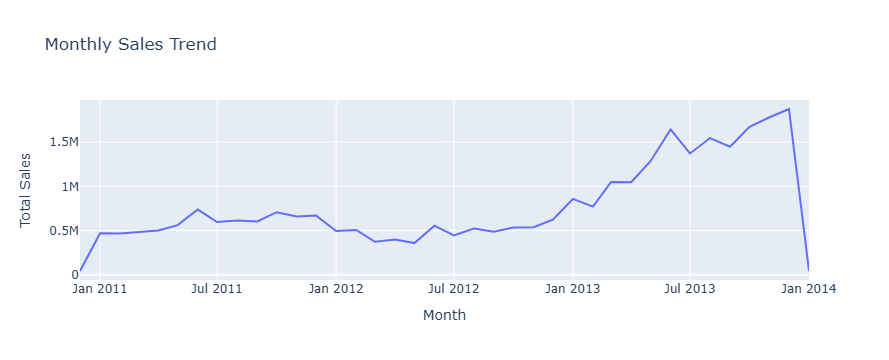

In [5]:
  # --- 1. Define the SQL Query for the time-series analysis ---
  sql_query_2 = """
      SELECT
          DATE_TRUNC('month', order_date) AS sales_month,
          SUM(sales_amount) AS total_sales
      FROM gold.fact_sales
      WHERE order_date IS NOT NULL
      GROUP BY sales_month
      ORDER BY sales_month;
  """

  # --- 2. Execute the Query and Load into a new DataFrame ---
  try:
      # Use pandas to execute the query
      sales_trend_df = pd.read_sql_query(sql_query_2, conn)
      print("Successfully loaded sales trend data.")

      # --- 3. Create the Visualization with Plotly Express ---
      fig = px.line(
          sales_trend_df,
          x='sales_month',
          y='total_sales',
          title='Monthly Sales Trend',
          labels={'sales_month': 'Month', 'total_sales': 'Total Sales'}
      )

      # Show the figure
      fig.show()

  except Exception as e:
      print(f"Error: Could not execute the query. {e}")

Successfully loaded category sales data.


C:\Users\Nitro\AppData\Local\Temp\ipykernel_2504\1409331909.py:24: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



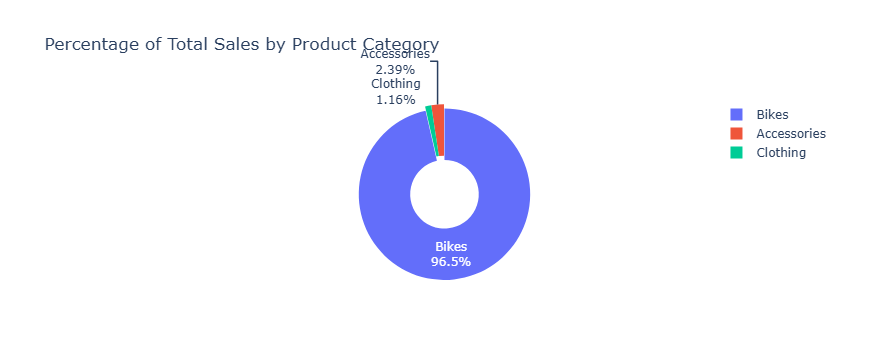

In [7]:
  # --- 1. Define the SQL Query for the part-to-whole analysis ---
  sql_query_3 = """
      WITH category_sales AS (
          SELECT
              p.category,
              SUM(f.sales_amount) AS total_sales
          FROM gold.fact_sales f
          LEFT JOIN gold.dim_products p
              ON p.product_key = f.product_key
          GROUP BY p.category
      )
      SELECT
          category,
          total_sales,
          -- We cast to NUMERIC for precision in PostgreSQL
          ROUND((total_sales::NUMERIC / SUM(total_sales) OVER ()) * 100, 2) AS percentage_of_total
      FROM category_sales
      ORDER BY total_sales DESC;
  """

  # --- 2. Execute the Query and Load into a new DataFrame ---
  try:
      # Use pandas to execute the query
      category_sales_df = pd.read_sql_query(sql_query_3, conn)
      print("Successfully loaded category sales data.")

      # --- 3. Create the Donut Chart with Plotly Express ---
      fig = px.pie(
          category_sales_df,
          names='category',
          values='total_sales', # For a pie chart, we use the raw values, and Plotly calculates the percentages
          title='Percentage of Total Sales by Product Category',
          hole=0.4  # This is the parameter that creates the donut hole
      )
    
      # Improve the layout
      fig.update_traces(textinfo='percent+label', pull=[0.05, 0, 0]) # Pull the first slice out slightly
    
      # Show the figure
      fig.show()

  except Exception as e:
      print(f"Error: Could not execute the query. {e}")

Loading customer segmentation data...


C:\Users\Nitro\AppData\Local\Temp\ipykernel_2504\1605637969.py:11: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



Successfully loaded data.


C:\Users\Nitro\AppData\Local\Temp\ipykernel_2504\1605637969.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




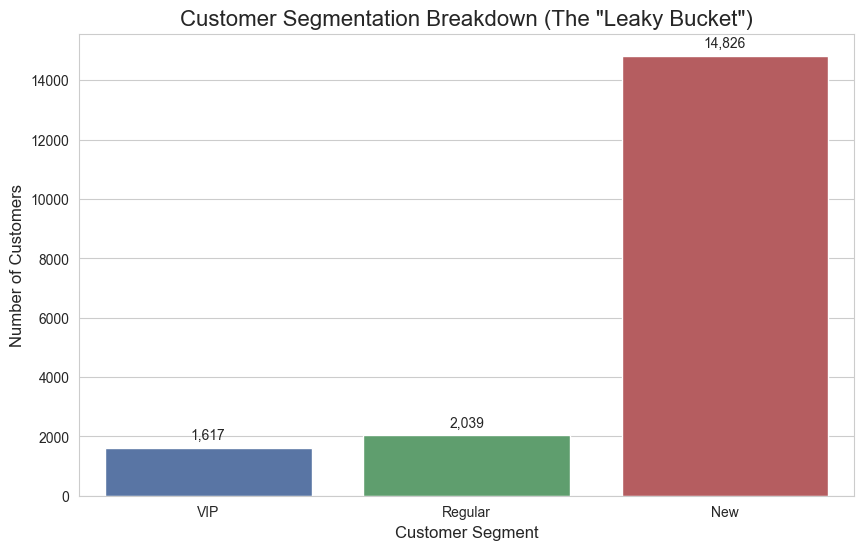

In [8]:
  # --- 1. Define the SQL Query for Customer Segmentation ---
  # We can query our final report view, which already has the logic.
  sql_query_segmentation = """
      SELECT customer_segment
      FROM gold.report_customers;
  """

  # --- 2. Execute the Query and Load into a DataFrame ---
  try:
      print("Loading customer segmentation data...")
      customer_segment_df = pd.read_sql_query(sql_query_segmentation, conn)
      print("Successfully loaded data.")

      # --- 3. Create the Visualization with Seaborn ---
      # Set the figure size and style
      plt.figure(figsize=(10, 6))
      sns.set_style("whitegrid")

      # Create the count plot
      ax = sns.countplot(
          data=customer_segment_df,
          x='customer_segment',
          # Order the bars logically
          order=['VIP', 'Regular', 'New'],
          palette=['#4c72b0', '#55a868', '#c44e52']
      )

      # Set titles and labels
      plt.title('Customer Segmentation Breakdown (The "Leaky Bucket")', fontsize=16)
      plt.xlabel('Customer Segment', fontsize=12)
      plt.ylabel('Number of Customers', fontsize=12)

      # Add count labels on top of each bar for clarity
      for p in ax.patches:
          ax.annotate(f'{int(p.get_height()):,}',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center',
                      xytext=(0, 9),
                      textcoords='offset points')

      # Display the plot
      plt.show()

  except Exception as e:
      print(f"Error: {e}")

Loading AOV by segment data...


C:\Users\Nitro\AppData\Local\Temp\ipykernel_2504\3295090309.py:14: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



Successfully loaded data.


C:\Users\Nitro\AppData\Local\Temp\ipykernel_2504\3295090309.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




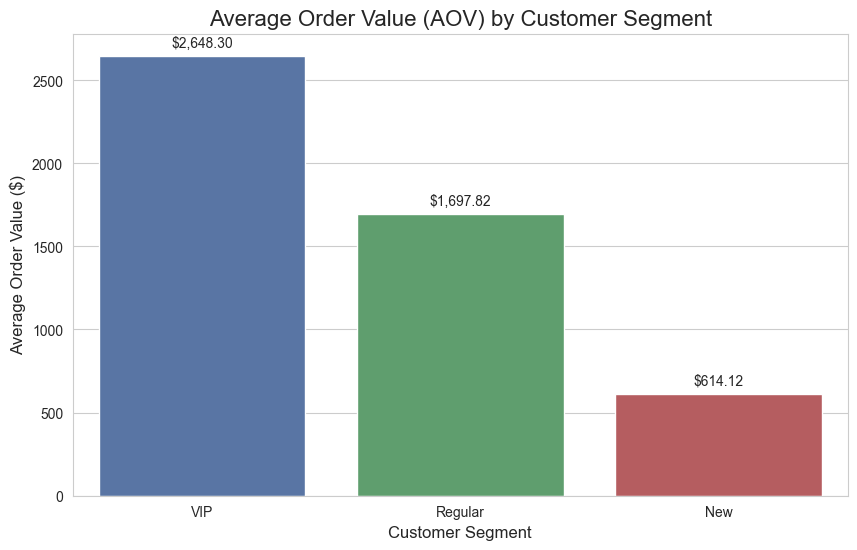

In [9]:
  # --- 1. Define the SQL Query for AOV by Segment ---
  # We will calculate the average of the AOV for all customers within each segment.
  sql_query_aov = """
      SELECT
          customer_segment,
          AVG(avg_order_value) AS average_aov
      FROM gold.report_customers
      GROUP BY customer_segment;
  """

  # --- 2. Execute the Query and Load into a DataFrame ---
  try:
      print("Loading AOV by segment data...")
      aov_segment_df = pd.read_sql_query(sql_query_aov, conn)
      print("Successfully loaded data.")

      # --- 3. Create the Visualization with Seaborn ---
      plt.figure(figsize=(10, 6))
      sns.set_style("whitegrid")

      ax = sns.barplot(
          data=aov_segment_df,
          x='customer_segment',
          y='average_aov',
          order=['VIP', 'Regular', 'New'], # Use the same order for consistency
          palette=['#4c72b0', '#55a868', '#c44e52']
      )

      plt.title('Average Order Value (AOV) by Customer Segment', fontsize=16)
      plt.xlabel('Customer Segment', fontsize=12)
      plt.ylabel('Average Order Value ($)', fontsize=12)

      # Add value labels on top of the bars
      for p in ax.patches:
          ax.annotate(f'${p.get_height():,.2f}',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center',
                      xytext=(0, 9),
                      textcoords='offset points')

      plt.show()

  except Exception as e:
      print(f"Error: {e}")

Loading VIP customer age data...
Successfully loaded data.


C:\Users\Nitro\AppData\Local\Temp\ipykernel_2504\1696845638.py:12: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\Nitro\AppData\Local\Temp\ipykernel_2504\1696845638.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




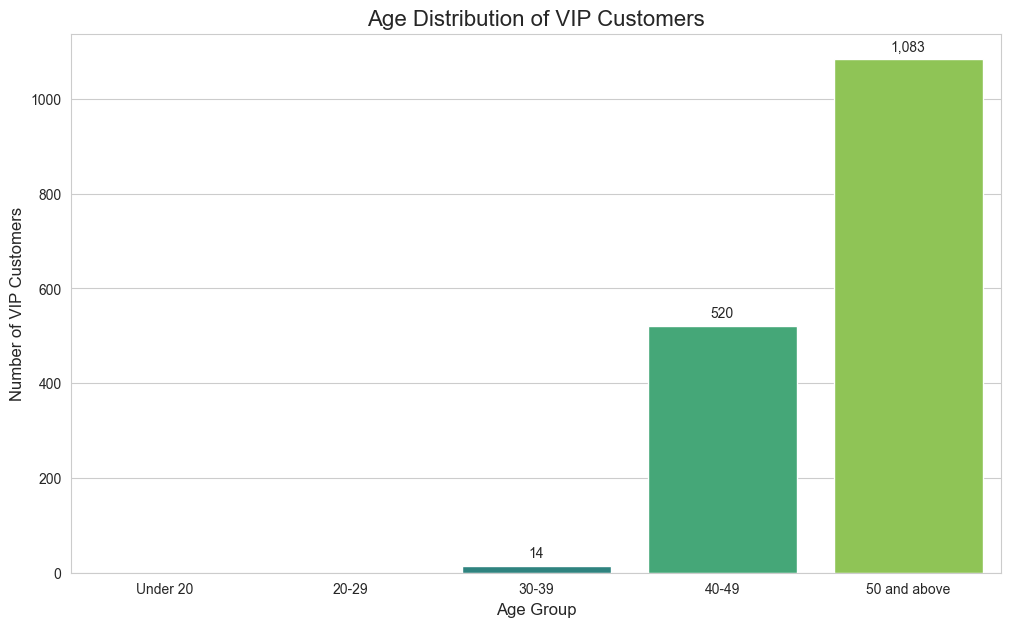

In [10]:
  # --- 1. Define the SQL Query for VIP Age Demographics ---
  # We will select the age_group for only the VIP customers.
  sql_query_vip_age = """
      SELECT age_group
      FROM gold.report_customers
      WHERE customer_segment = 'VIP';
  """

  # --- 2. Execute the Query and Load into a DataFrame ---
  try:
      print("Loading VIP customer age data...")
      vip_age_df = pd.read_sql_query(sql_query_vip_age, conn)
      print("Successfully loaded data.")

      # --- 3. Create the Visualization with Seaborn ---
      plt.figure(figsize=(12, 7))
      sns.set_style("whitegrid")

      # Define a logical order for the age groups for the x-axis
      age_order = ['Under 20', '20-29', '30-39', '40-49', '50 and above']

      ax = sns.countplot(
          data=vip_age_df,
          x='age_group',
          order=age_order,
          palette='viridis'
      )

      plt.title('Age Distribution of VIP Customers', fontsize=16)
      plt.xlabel('Age Group', fontsize=12)
      plt.ylabel('Number of VIP Customers', fontsize=12)

      # Add count labels on top of the bars
      for p in ax.patches:
          ax.annotate(f'{int(p.get_height()):,}',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center',
                      xytext=(0, 9),
                      textcoords='offset points')

      plt.show()

  except Exception as e:
      print(f"Error: {e}")

Loading cumulative sales data...
Successfully loaded data.


C:\Users\Nitro\AppData\Local\Temp\ipykernel_2504\2640706391.py:23: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



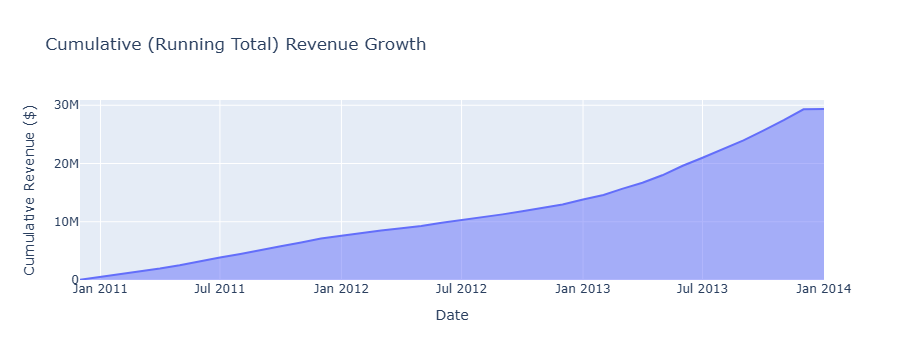

In [11]:
  # --- 1. Define the SQL Query for Cumulative Revenue ---
  # This query first calculates monthly sales, then uses a window function
  # to create a running total (cumulative sum).
  sql_query_cumulative = """
      WITH monthly_sales AS (
          SELECT
              DATE_TRUNC('month', order_date) AS sales_month,
              SUM(sales_amount) AS total_sales
          FROM gold.fact_sales
          WHERE order_date IS NOT NULL
          GROUP BY sales_month
      )
      SELECT
          sales_month,
          SUM(total_sales) OVER (ORDER BY sales_month) AS cumulative_sales
      FROM monthly_sales
      ORDER BY sales_month;
  """

  # --- 2. Execute the Query and Load into a DataFrame ---
  try:
      print("Loading cumulative sales data...")
      cumulative_sales_df = pd.read_sql_query(sql_query_cumulative, conn)
      print("Successfully loaded data.")

      # --- 3. Create the Visualization with Plotly Express ---
      # An area chart is perfect for showing cumulative data.
      fig = px.area(
          cumulative_sales_df,
          x='sales_month',
          y='cumulative_sales',
          title='Cumulative (Running Total) Revenue Growth',
          labels={'sales_month': 'Month', 'cumulative_sales': 'Cumulative Revenue'}
      )

      # Improve axis labels
      fig.update_layout(
          yaxis_title='Cumulative Revenue ($)',
          xaxis_title='Date'
      )

      fig.show()

  except Exception as e:
      print(f"Error: {e}")

Loading top 10 customer data...
Successfully loaded data.


C:\Users\Nitro\AppData\Local\Temp\ipykernel_2504\2583220700.py:15: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



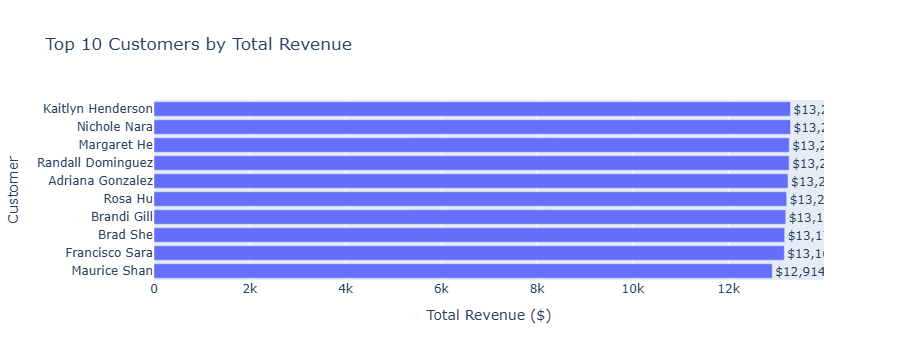

In [12]:
  # --- 1. Define the SQL Query for Top 10 Customers ---
  # We can get this directly from our customer report view.
  sql_query_top_customers = """
      SELECT
          customer_name,
          total_sales
      FROM gold.report_customers
      ORDER BY total_sales DESC
      LIMIT 10;
  """

  # --- 2. Execute the Query and Load into a DataFrame ---
  try:
      print("Loading top 10 customer data...")
      top_customers_df = pd.read_sql_query(sql_query_top_customers, conn)
      print("Successfully loaded data.")

      # --- 3. Create the Visualization with Plotly Express ---
      # A horizontal bar chart is best for ranked lists with long labels.
      fig = px.bar(
          top_customers_df,
          x='total_sales',
          y='customer_name',
          orientation='h',
          title='Top 10 Customers by Total Revenue',
          labels={'customer_name': 'Customer', 'total_sales': 'Total Revenue'},
          text='total_sales' # This will display the value on the bar
      )

      # Improve layout and order the bars so the top customer is at the top
      fig.update_layout(
          yaxis={'categoryorder':'total ascending'},
          xaxis_title='Total Revenue ($)',
          yaxis_title='Customer'
      )

      # Format the text displayed on the bars for better readability
      fig.update_traces(texttemplate='$%{text:,.0f}', textposition='outside')

      fig.show()

  except Exception as e:
      print(f"Error: {e}")

Loading top 5 product data...
Successfully loaded data.


C:\Users\Nitro\AppData\Local\Temp\ipykernel_2504\1340540382.py:15: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



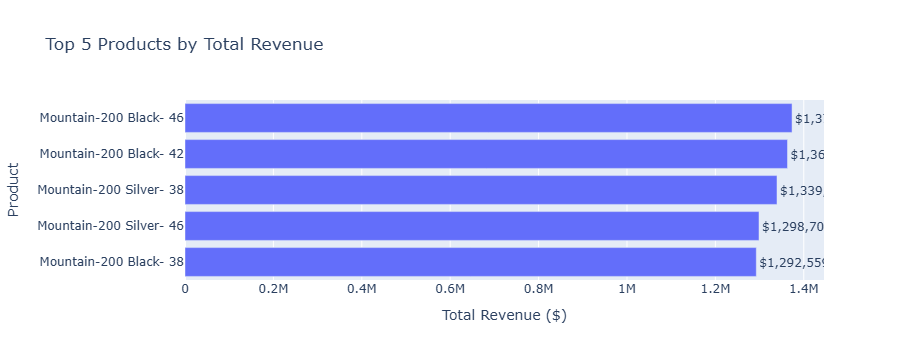

In [13]:
  # --- 1. Define the SQL Query for Top 5 Products ---
  # We can get this directly from our product report view.
  sql_query_top_products = """
      SELECT
          product_name,
          total_sales
      FROM gold.report_products
      ORDER BY total_sales DESC
      LIMIT 5;
  """

  # --- 2. Execute the Query and Load into a DataFrame ---
  try:
      print("Loading top 5 product data...")
      top_products_df = pd.read_sql_query(sql_query_top_products, conn)
      print("Successfully loaded data.")

      # --- 3. Create the Visualization with Plotly Express ---
      fig = px.bar(
          top_products_df,
          x='total_sales',
          y='product_name',
          orientation='h',
          title='Top 5 Products by Total Revenue',
          labels={'product_name': 'Product', 'total_sales': 'Total Revenue'},
          text='total_sales'
      )

      # Improve layout and order the bars
      fig.update_layout(
          yaxis={'categoryorder':'total ascending'},
          xaxis_title='Total Revenue ($)',
          yaxis_title='Product'
      )

      # Format the text on the bars
      fig.update_traces(texttemplate='$%{text:,.0f}', textposition='outside')

      fig.show()

  except Exception as e:
      print(f"Error: {e}")

Loading Year-over-Year sales data for top products...
Successfully loaded data.


C:\Users\Nitro\AppData\Local\Temp\ipykernel_2504\1792785204.py:29: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



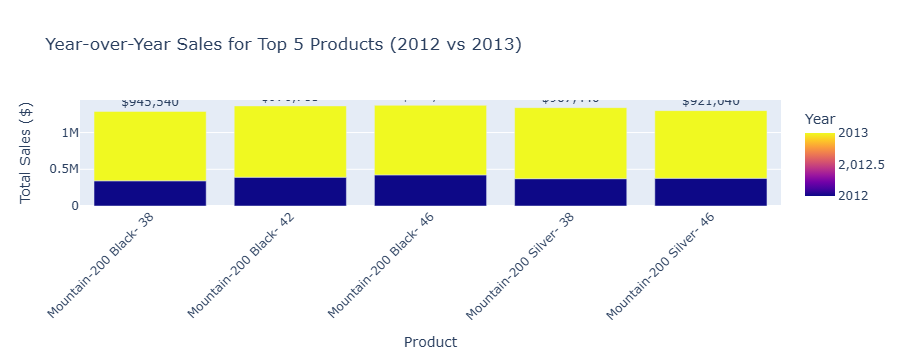

In [14]:
  # --- 1. Define the SQL Query for YoY Performance of Top Products ---
  sql_query_yoy = """
      SELECT
          EXTRACT(YEAR FROM f.order_date) AS order_year,
          p.product_name,
          SUM(f.sales_amount) AS total_sales
      FROM gold.fact_sales f
      LEFT JOIN gold.dim_products p
          ON f.product_key = p.product_key
      WHERE p.product_name IN (
          -- We'll focus on the top 5 products for a cleaner visual
          SELECT product_name
          FROM gold.report_products
          ORDER BY total_sales DESC
          LIMIT 5
      )
      AND EXTRACT(YEAR FROM f.order_date) IN (2012, 2013) -- Compare the two key years
      GROUP BY
          order_year,
          p.product_name
      ORDER BY
          p.product_name,
          order_year;
  """

  # --- 2. Execute the Query and Load into a DataFrame ---
  try:
      print("Loading Year-over-Year sales data for top products...")
      yoy_sales_df = pd.read_sql_query(sql_query_yoy, conn)
      print("Successfully loaded data.")

      # --- 3. Create the Grouped Bar Chart with Plotly Express ---
      fig = px.bar(
          yoy_sales_df,
          x='product_name',
          y='total_sales',
          color='order_year', # This creates the grouping by year
          barmode='group',    # This places the bars side-by-side
          title='Year-over-Year Sales for Top 5 Products (2012 vs 2013)',
          labels={'product_name': 'Product', 'total_sales': 'Total Sales', 'order_year': 'Year'},
          text='total_sales'
      )

      fig.update_layout(
          xaxis_title='Product',
          yaxis_title='Total Sales ($)',
          xaxis_tickangle=-45 # Angle the x-axis labels for better readability
      )

      fig.update_traces(texttemplate='$%{text:,.0f}', textposition='outside')

      fig.show()

  except Exception as e:
      print(f"Error: {e}")

Loading customer distribution by country data...
Successfully loaded data.


C:\Users\Nitro\AppData\Local\Temp\ipykernel_2504\4290353914.py:13: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



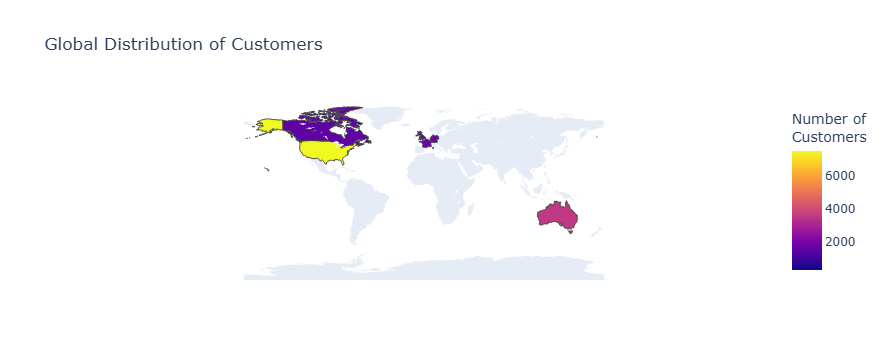

In [15]:
  sql_query_country = """
      SELECT
          country,
          COUNT(customer_key) AS customer_count
      FROM gold.dim_customers
      GROUP BY country
      ORDER BY customer_count DESC;
  """

  # --- 2. Execute the Query and Load into a DataFrame ---
  try:
      print("Loading customer distribution by country data...")
      country_df = pd.read_sql_query(sql_query_country, conn)
      print("Successfully loaded data.")

      # --- 3. Map Country Names to ISO-3 Codes for Plotly ---
      # Plotly's choropleth maps require standard three-letter country codes.
      country_iso_map = {
          'United States': 'USA',
          'Australia': 'AUS',
          'United Kingdom': 'GBR',
          'Germany': 'DEU',
          'France': 'FRA',
          'Canada': 'CAN'
      }
      country_df['iso_alpha'] = country_df['country'].map(country_iso_map)

      # --- 4. Create the Choropleth Map with Plotly Express ---
      fig = px.choropleth(
          country_df,
          locations="iso_alpha",
          color="customer_count",
          hover_name="country",
          color_continuous_scale=px.colors.sequential.Plasma,
          title="Global Distribution of Customers"
      )

      fig.update_layout(
          geo=dict(
              showframe=False,
              showcoastlines=False,
              projection_type='equirectangular'
          ),
          coloraxis_colorbar=dict(
              title="Number of<br>Customers"
          )
      )

      fig.show()

  except Exception as e:
      print(f"Error: {e}")

Loading bottom 5 product data...
Successfully loaded data.


C:\Users\Nitro\AppData\Local\Temp\ipykernel_2504\1052297152.py:15: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



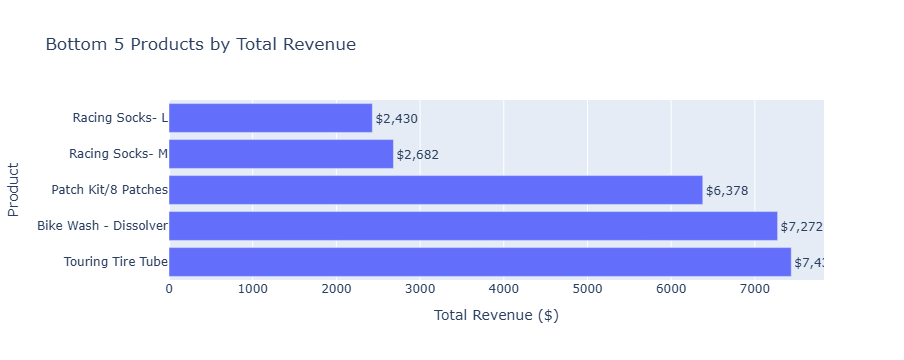

In [16]:
  # --- 1. Define the SQL Query for Bottom 5 Products ---
  sql_query_bottom_products = """
      SELECT
          product_name,
          total_sales
      FROM gold.report_products
      WHERE total_sales > 0 -- Exclude products with zero sales
      ORDER BY total_sales ASC
      LIMIT 5;
  """

  # --- 2. Execute the Query and Load into a DataFrame ---
  try:
      print("Loading bottom 5 product data...")
      bottom_products_df = pd.read_sql_query(sql_query_bottom_products, conn)
      print("Successfully loaded data.")

      # --- 3. Create the Visualization with Plotly Express ---
      fig = px.bar(
          bottom_products_df,
          x='total_sales',
          y='product_name',
          orientation='h',
          title='Bottom 5 Products by Total Revenue',
          labels={'product_name': 'Product', 'total_sales': 'Total Revenue'},
          text='total_sales'
      )

      # Improve layout and order to show the lowest value at the top
      fig.update_layout(
          yaxis={'categoryorder':'total descending'},
          xaxis_title='Total Revenue ($)',
          yaxis_title='Product'
      )

      # Format the text on the bars
      fig.update_traces(texttemplate='$%{text:,.0f}', textposition='outside')

      fig.show()

  except Exception as e:
      print(f"Error: {e}")

Loading product cost segmentation data...
Successfully loaded data.


C:\Users\Nitro\AppData\Local\Temp\ipykernel_2504\2364673009.py:24: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\Nitro\AppData\Local\Temp\ipykernel_2504\2364673009.py:34: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




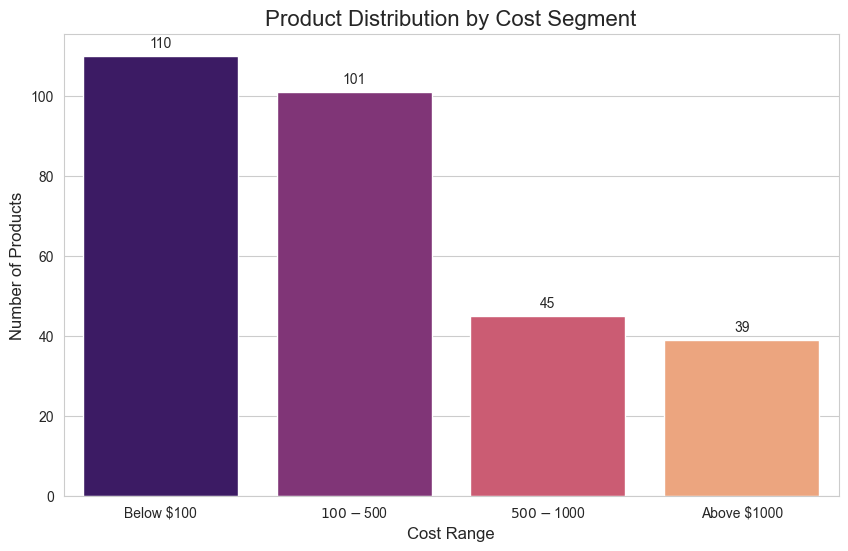

In [17]:
  # --- 1. Define the SQL Query for Product Cost Segmentation ---
  sql_query_cost_segment = """
      WITH product_segments AS (
          SELECT
              CASE
                  WHEN cost < 100 THEN 'Below $100'
                  WHEN cost BETWEEN 100 AND 500 THEN '$100-$500'
                  WHEN cost BETWEEN 500 AND 1000 THEN '$500-$1000'
                  ELSE 'Above $1000'
              END AS cost_range
          FROM gold.dim_products
          WHERE cost IS NOT NULL
      )
      SELECT
          cost_range,
          COUNT(*) AS product_count
      FROM product_segments
      GROUP BY cost_range;
  """

  # --- 2. Execute the Query and Load into a DataFrame ---
  try:
      print("Loading product cost segmentation data...")
      cost_segment_df = pd.read_sql_query(sql_query_cost_segment, conn)
      print("Successfully loaded data.")

      # --- 3. Create the Visualization with Seaborn ---
      plt.figure(figsize=(10, 6))
      sns.set_style("whitegrid")

      # Define a logical order for the cost ranges
      cost_order = ['Below $100', '$100-$500', '$500-$1000', 'Above $1000']

      ax = sns.barplot(
          data=cost_segment_df,
          x='cost_range',
          y='product_count',
          order=cost_order,
          palette='magma'
      )

      plt.title('Product Distribution by Cost Segment', fontsize=16)
      plt.xlabel('Cost Range', fontsize=12)
      plt.ylabel('Number of Products', fontsize=12)

      # Add count labels on top of the bars
      for p in ax.patches:
          ax.annotate(f'{int(p.get_height()):,}',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center',
                      xytext=(0, 9),
                      textcoords='offset points')

      plt.show()

  except Exception as e:
      print(f"Error: {e}")

Using the kpi_df DataFrame created earlier:


,measure_name,measure_value
0,Total Sales,2.935625e+07
1,Total Quantity,6.042300e+04
2,Average Price,4.860378e+02
3,Total Orders,2.765900e+04
4,Total Products,2.950000e+02
5,Total Customers,1.848400e+04


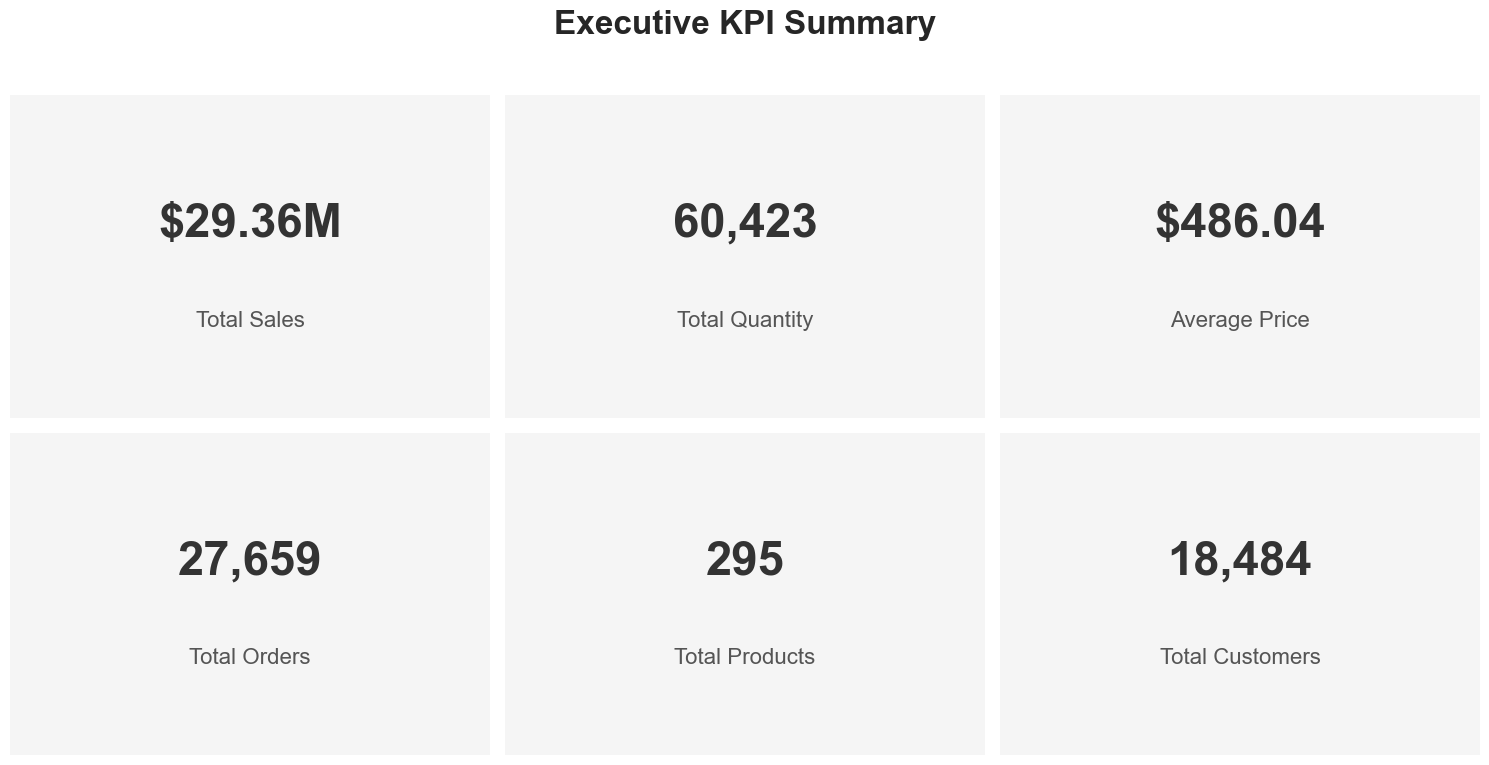

In [18]:
  # --- Create KPI Card Visualizations ---

  # We already have the kpi_df DataFrame loaded in memory from cell 3.
  # Let's re-display it to remember its contents.
  print("Using the kpi_df DataFrame created earlier:")
  display(kpi_df)

  # --- Create a figure with subplots for our KPI cards ---
  fig, axes = plt.subplots(2, 3, figsize=(15, 8))
  fig.suptitle('Executive KPI Summary', fontsize=24, fontweight='bold')

  # Flatten the axes array for easy iteration
  axes = axes.flatten()

  # --- Helper function for formatting large numbers ---
  def format_kpi_value(value):
      if value >= 1_000_000:
          return f'${value/1_000_000:.2f}M'
      elif value >= 1_000:
          return f'${value/1_000:.1f}K'
      else:
          return f'${value:,.2f}'

  # --- Iterate through the KPI data and create a card for each ---
  for i, row in kpi_df.iterrows():
      ax = axes[i]
      measure_name = row['measure_name']
      measure_value = row['measure_value']

      # Format the value for display based on its name
      if 'Sales' in measure_name or 'Price' in measure_name:
          display_value = format_kpi_value(measure_value)
      else:
          display_value = f'{int(measure_value):,}'

      # Create the card content
      ax.text(0.5, 0.6, display_value, ha='center', va='center', fontsize=34, fontweight='bold', color='#333')
      ax.text(0.5, 0.3, measure_name, ha='center', va='center', fontsize=16, color='#555')

      # Style the card
      ax.set_xticks([])
      ax.set_yticks([])
      ax.spines['top'].set_visible(False)
      ax.spines['right'].set_visible(False)
      ax.spines['bottom'].set_visible(False)
      ax.spines['left'].set_visible(False)
      ax.set_facecolor('#f5f5f5') # Set a light background color for the card

  # Hide any unused subplots if we have fewer than 6 KPIs
  for j in range(len(kpi_df), len(axes)):
      axes[j].set_visible(False)

  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for the suptitle
  plt.show()